In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import glob
import natsort    # 파일명 정렬
import cv2
import pandas as pd
import numpy as np
import math
import copy
import time

# path = '/content/gdrive/MyDrive/Colab Notebooks/eye_writing_data/csv_raw_data/01/'
# path_for_glob = '/content/gdrive/MyDrive/Colab Notebooks/eye_writing_data/csv_raw_data/*'
path_for_glob = '/content/gdrive/MyDrive/Colab Notebooks/Recognitaion_eye_written_char_with_siamese_net/eye_writing_data/csv_eb_removed/*'


# file_list = os.listdir(path)                            # 파일명 만
file_path_list = glob.glob(path_for_glob)                 # 경로 전체

sorted_file_path_list = natsort.natsorted(file_path_list)     # str 파일 숫자로 정렬 함수
# print(sorted_file_path_list)
 
raw_data_list = []
file_names_list = []

for i in range(len(sorted_file_path_list)):
  file_names = os.listdir(sorted_file_path_list[i])
  file_names = natsort.natsorted(file_names)
  file_names_list.extend(file_names)
  # print(file_names)

  for f in file_names :
    raw_data = pd.read_csv(sorted_file_path_list[i] +'/'+ f , header=None)
    raw_data = raw_data.values.tolist()
    raw_data_list.append(raw_data)

# print(raw_data_list[0])
# print(np.array(raw_data_list)[0])
# print(file_names_list[0])


In [ ]:
import matplotlib.pyplot as plt

def plot_images(input_list,fig,axes):        # input_list plot 함수
  '''
  input_list의 한 데이터(file)내의 x,y 좌표 시각화
  한 데이터에서 (0,0)을 기준으로 가장 멀리 있는 값 (max_val)을 plot의 범위로 지정
  '''
 
  for n in range(len(input_list)):
    x,y = zip(*input_list[n])
    max_val = get_max_coor_val(x,y)
 
    axes[n].set_xlim([math.floor(-max_val)*1.2,math.ceil(max_val)*1.2])
    axes[n].set_ylim([math.floor(-max_val)*1.2,math.ceil(max_val)*1.2])
 
    axes[n].scatter(x,y)
    axes[n].plot(x,y)
 
  fig.tight_layout()
  # display(fig)

  plt.savefig('savefig_default.png')



In [ ]:
def get_max_coor_val(x,y):
  '''
  x,y 좌표 중 원점(0,0)을 기준으로 가장 멀리있는 값 return
  '''
 
  temp_max_x = abs(max(x))
  temp_min_x = abs(min(x))
  temp_max_y = abs(max(y))
  temp_min_y = abs(min(y))
 
  if temp_max_x >= temp_min_x:
    max_x = temp_max_x
  else :
    max_x = temp_min_x
 
  if temp_max_y >= temp_min_y:
    max_y = temp_max_y
  else :
    max_y = temp_min_y
 
  if max_x >= max_y:
    max_val = max_x
  else:
    max_val = max_y
 
  return max_val
 
def get_lim_range_val(input_list):
  '''
  범위 정규화를 위한 요소의 최대값 return
  '''
 
  data_list = copy.deepcopy(input_list)
  
  max_val_list = []
  for n in range(len(data_list)):
    x,y = zip(*data_list[n])
    max_val_list.append(get_max_coor_val(x,y))
 
  mean_max_val = np.mean(max_val_list)
 
  return mean_max_val
 
def coordinates_range_rescaling(input_list):          # data_list 좌표 범위 정규화 (각 좌표 별 max 값 일반화)
  '''
  한계 점을 기준으로 전체 데이터 축소 혹은 확장 하는 함수
  ※ 모든 좌표를 정규화 시키기 위해 -1 ~ 1 사이의 값으로 변환
  '''
 
  data_list = copy.deepcopy(input_list)
 
  # lim_range = get_lim_range_val(data_list)
 
  range_convered_data_list = []
 
  for n in range(len(data_list)):
    x,y = zip(*data_list[n])
    max_val = get_max_coor_val(x,y)
 
    # conversion_ratio = (lim_range / max_val)
    conversion_ratio = (1 / max_val)          # -1 ~ 1 사이의 값으로 정규화
 
    convered_x_list = []
    convered_y_list = []
 
    for i in range(len(data_list[n])):
      convered_x_list.append(round(x[i] * conversion_ratio,6))
      convered_y_list.append(round(y[i] * conversion_ratio,6))
 
    range_convered_data_list.append(list(zip(convered_x_list,convered_y_list)))
 
  return range_convered_data_list

In [ ]:
def get_extents_of_spread_val(input_list, slicing_range):
  data_list = copy.deepcopy(input_list)
  
  std_extents_of_spread = []
  std_extents_of_spread_list = []

  for i in range(0,len(data_list),slicing_range):
        
    split_data = data_list[i:i + slicing_range]

    mean_x = round(np.mean(split_data,axis=0)[0],6)     # x의 중심 값
    mean_y = round(np.mean(split_data,axis=0)[1],6)     # y의 중심 값
 
    x_distance = []
    y_distance = []
    for x,y in split_data:                                            # 중앙 값과의 거리
      x_distance.append(round(abs(x - mean_x),6))
      y_distance.append(round(abs(y - mean_y),6))
    
    distance_between_coordinates = list(zip(x_distance,y_distance))

    std_extents_of_spread = round(np.std(distance_between_coordinates),6)
    std_extents_of_spread_list.append(std_extents_of_spread)

  mean_extents_of_spread = round(np.mean(std_extents_of_spread_list),6)

  return mean_extents_of_spread

def noise_removal(input_list, slicing_range = 5):           # 불필요한 좌표 제거 (각 파일별 좌표 축소), slicing_range :  몇개 단위
  data_list = copy.deepcopy(input_list)
  
  noise_removed_data_list = []
 
  for i in range(len(data_list)):
    each_data = data_list[i]
 
    nCoor = len(each_data)             # 한 데이터의 점 개수
    total_extents_of_spread = get_extents_of_spread_val(each_data,slicing_range)
     
    ratio = 1.75                                  # mean_std_value를 기준, 디테일 범위 1.5 or 1.75 or 2
    custom_data = []

    before_nCoor = nCoor
    after_nCoor = -1
    while before_nCoor > after_nCoor:   # 더 이상 줄일 수 없을 때 까지 / ex) 100 -> 84 -> 65 -> 65
      temp_data = []
 
      for i in range(0,nCoor,slicing_range):
 
        if before_nCoor == nCoor :                     
          split_data = each_data[i:i + slicing_range]      # 1회차의 경우 custom list는 비어있음
        else :
          split_data = custom_data[i:i + slicing_range]
        
        split_data_extents_of_spread = get_extents_of_spread_val(split_data, slicing_range)
        
        if split_data_extents_of_spread <= total_extents_of_spread * ratio :   # 데이터가 모여있을 경우 데이터 축소 5 -> 1
          x,y = zip(*split_data)
 
          x_mean = round(np.mean(x),6)
          y_mean = round(np.mean(y),6)
 
          temp_coor = [x_mean,y_mean]
 
          temp_data.append(temp_coor)
        else:
          temp_data.extend(split_data)
 
      custom_data = temp_data         # custom data 최신화
              
      nCoor = len(temp_data)      # 좌표 개수 최신화
      
      if after_nCoor == -1 :
        after_nCoor = nCoor
      else : 
        before_nCoor = after_nCoor
        after_nCoor = nCoor
      
    noise_removed_data_list.append(custom_data)
  
  return noise_removed_data_list

In [ ]:
def get_necessary_coor_num(input_list):
 
  data_list = copy.deepcopy(input_list)
 
  # (smallest_len_value : ?)  (max_total_len_value : ?) (maximun_nCoor : ?)
 
  smallest_len_list = []
  add_len_list = []
  coor_count_list = []
  len_list = []
 
  for n in range(len(data_list)):
    temp_list = data_list[n]
 
    coor_count_list.append(len(temp_list))
 
    coor_list = []
    for i in range(len(temp_list)-1):
      coor_list.append(temp_list[i:i+2])
    
    temp_len_list = []
    for i in range(len(coor_list)):
      coor = coor_list[i]
      each_len = round(math.sqrt(math.pow(coor[0][0]-coor[1][0],2) + math.pow(coor[0][1]-coor[1][1],2)),6)
      temp_len_list.append(each_len)
 
    len_list.append(temp_len_list)
    add_len_list.append(round(sum(len_list[n]),6))
    smallest_len_list.append(min(temp_len_list))
 
 
  # print("\n ======= result =======")
 
  # print("len_list : {} ".format(len_list))
  # print("coor_count_list : {}".format(coor_count_list))
  # print("add_len_list : {} ".format(add_len_list))
  # print("smallest_len_list : {} \n".format(smallest_len_list))
 
  smallest_len_value = min(smallest_len_list)
  maximun_nCoor = max(coor_count_list)
  maximum_total_len_value = max(add_len_list)
 
  # print("smallest_len_value : {} ".format(smallest_len_value))
  # print("maximun_nCoor : {}".format(maximun_nCoor))
  # print("maximum_total_len_value : {} \n".format(maximum_total_len_value))
 
  
  required_nCoor = []
 
  for i in range(len(len_list)):
    min_len = np.min(len_list[i])
    
    if min_len == 0.0:
      min_len = np.sort(len_list[i])[1]
 
    round_list = []
 
    for each_len in len_list[i]:
      round_list.append(round((each_len/min_len),0))
    
    required_nCoor.append(sum(round_list))
 
  # print('required_nCoor : {}'.format(required_nCoor))
 
  required_nCoor.sort()
  
  # print('max of required coor : {} '.format(max(required_nCoor)))
  # print('min of required coor : {} '.format(min(required_nCoor)))
  # print('mean of required coor : {} '.format(round(np.nanmean(required_nCoor),0)))
  # print('median of required coor : {} '.format(round(np.nanmedian(required_nCoor),0)))
 
  num_of_coor = round(np.nanmedian(required_nCoor),0)
  # print('num of coor : {}'.format(num_of_coor))
 
  return num_of_coor, add_len_list

In [ ]:
def get_new_coor_list(coor, k):
  new_x_list = []
  new_y_list = []

  for j in range(1,k+1):
    if coor[0][0] < coor[1][0] :
      new_x = round( coor[0][0] + (j/k) * abs(coor[0][0]-coor[1][0]) ,6)
    else :
      new_x = round( coor[0][0] - (j/k) * abs(coor[0][0]-coor[1][0]) ,6)
    
    if coor[0][1] < coor[1][1] :
      new_y = round( coor[0][1] + (j/k) * abs(coor[0][1]-coor[1][1]) ,6)
    else :
      new_y = round( coor[0][1] - (j/k) * abs(coor[0][1]-coor[1][1]) ,6)
    
    new_x_list.append(new_x)
    new_y_list.append(new_y)

  return new_x_list, new_y_list

def fill_coordinates(input_list, nCoor, add_len_list):

  data_list = copy.deepcopy(input_list)

  coordinates_filled_list = []
  for n in range(len(data_list)):

    temp_list = data_list[n]
    sum_len_value = add_len_list[n]
    minimum_len_value = round((sum_len_value / nCoor),6)

    # minimum_len_value = 0.005

    coor_list = []
    for i in range(len(temp_list)-1):
      coor_list.append(temp_list[i:i+2])

    renewal_coor_list = []
    for p in range(len(coor_list)):
      coor = coor_list[p]

      each_len = round(math.sqrt(math.pow(coor[0][0]-coor[1][0],2) + math.pow(coor[0][1]-coor[1][1],2)),6)
      
      if each_len > minimum_len_value :
        k = int(each_len // minimum_len_value)
        
        new_x, new_y = get_new_coor_list(coor, k)
        new_coor_list = list(zip(new_x,new_y))

        renewal_coor_list.append(coor[0])
        renewal_coor_list.extend(new_coor_list)
        renewal_coor_list.append(coor[1])
        
      else :
        renewal_coor_list.append(coor[0])
        renewal_coor_list.append(coor[1])
      
    x = []
    for y in renewal_coor_list:                      # 리스트 요소들 tuple로 통일
      x.append(tuple(y))

    removal_overlap_list = pd.unique(x).tolist()    # 튜플 중복 제거

    x = []
    for y in removal_overlap_list:                  # 튜플 -> 리스트
      x.append(list(y))
    removal_overlap_list = x
    
    coordinates_filled_list.append(removal_overlap_list)

  return coordinates_filled_list

In [ ]:
def get_new_coor(coor, each_len, coor_distance):

  x_distance = abs(coor[0][0]-coor[1][0])
  y_distance = abs(coor[0][1]-coor[1][1])

  x_t = round(x_distance * coor_distance / each_len,6)
  y_t = round(y_distance * coor_distance / each_len,6)

  if coor[0][0] < coor[1][0]:
    new_x = coor[0][0] + x_t
  else : 
    new_x = coor[0][0] - x_t

  if coor[0][1] < coor[1][1]:
    new_y = coor[0][1] + y_t
  else : 
    new_y = coor[0][1] - y_t

  return round(new_x ,6), round(new_y ,6)

def re_construction_distance(input_list,add_len_list):

  data_list = copy.deepcopy(input_list)

  renewal_list = []

  for i in range(len(data_list)):

    each_list = data_list[i]

    coor_count = len(data_list[i])
    add_len = add_len_list[i]

    coor_distance = round(add_len / coor_count,6)  

    coor_list = []
    for i in range(len(each_list)-1):         # 두 점씩 분리
      coor_list.append(each_list[i:i+2])

    for p in range(len(coor_list)):
      coor = coor_list[p]
    
      each_len = round(math.sqrt(math.pow(coor[0][0]-coor[1][0],2) + math.pow(coor[0][1]-coor[1][1],2)),6)

      coor_list[p][1][0], coor_list[p][1][1] = get_new_coor(coor, each_len, coor_distance)

      if p < len(coor_list)-1 :
        coor_list[p+1][0][0] = coor_list[p][1][0]
        coor_list[p+1][0][1] = coor_list[p][1][1]

    renewal_list.append(coor_list)

  result_list = []                           # 변경된 각 좌표 쌍 중 첫번 째 좌표만 추출
  for i in range(len(renewal_list)):
    temp_list = renewal_list[i]

    sampling_list = []
    for j in range(len(temp_list)):
      sampling_list.append(temp_list[j][0])

    result_list.append(sampling_list)
  
  return result_list

In [ ]:
def equalization_and_reduce_nCoor(input_list, goal_nCoor=200):

  data_list = copy.deepcopy(input_list)

  nCoor_list = []
  for i in range(len(data_list)):
    nCoor_list.append(len(data_list[i]))
  # print(nCoor_list)

  # 좌표 개수 통일 
  equalization_nCoor = np.min(nCoor_list)

  # print("equalization_nCoor : {}".format(equalization_nCoor))

  count = 0
  new_data_list = []
  for each_data in data_list:
    should_be_removed_data_num = len(each_data) - equalization_nCoor
  
    if should_be_removed_data_num == 0:
      new_data_list.append(each_data)
      continue

    t = int(len(each_data) / should_be_removed_data_num)
  
    for n in range(should_be_removed_data_num):
      each_data[t * n] = 0                             # 삭제 될 데이터를 (x,y) -> 0 으로 교체
  
    each_data = [d for d in each_data if d != 0]         # 리스트 내 0 값 제거
  
    count = count+1

    new_data_list.append(each_data)

  # 좌표 개수 줄이기

  while len(new_data_list[0]) > goal_nCoor:
  
    temp_list = []
    for each_data in new_data_list:
      
      t_list = []
      for i in range(len(each_data)):
        if i % 2 != 0:
          t_list.append(each_data[i])

      temp_list.append(t_list)

    new_data_list = temp_list

  return new_data_list

In [ ]:
def relocation_zero_2_nine(input_list, file_names_list):    # 0 ~ 539 -> 0~9 * 54
  data_list = copy.deepcopy(input_list)
  name_list = copy.deepcopy(file_names_list)

  # 0~9 사이 섞인 데이터를 같은 숫자끼리 재배치
  relocation_data_list = []
  for i in range(0,10):
    temp_list = []
    for j in range(0,len(data_list),10):
      temp_list.append(data_list[i+j])

    relocation_data_list.append(temp_list)

  relocation_name_list = []
  for i in range(0,10):
    temp_list = []
    for j in range(0,len(name_list),10):
      temp_list.append(name_list[i+j])

    relocation_name_list.append(temp_list)

  return relocation_data_list, relocation_name_list

In [ ]:
# running 
start = time.time()


range_convered_data_list = coordinates_range_rescaling(raw_data_list)
# print(range_convered_data_list[0])

noise_removed_data_list = noise_removal(range_convered_data_list)
# print(noise_removed_data_list[0])

num_of_coor, add_len_list = get_necessary_coor_num(noise_removed_data_list)
# print('\n num_of_coor : {}'.format(num_of_coor))
# print(' add_len_list : {} \n'.format(add_len_list))

coordinates_filled_list = fill_coordinates(noise_removed_data_list, num_of_coor, add_len_list)
# print(coordinates_filled_list[0])

first_same_distance_data_list = re_construction_distance(coordinates_filled_list, add_len_list)
# print(first_same_distance_data_list[0])

reduced_num_of_coor_data_list = equalization_and_reduce_nCoor(first_same_distance_data_list)
# print(reduced_num_of_coor_data_list[0])

second_same_distance_data_list = re_construction_distance(reduced_num_of_coor_data_list, add_len_list)
# print(len(second_same_distance_data_list[0]))

relocation_data_list, relocation_name_list = relocation_zero_2_nine(second_same_distance_data_list, file_names_list)
# print(relocation_data_list[0])

print()
print('time : ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars



time :  40.788209438323975


In [ ]:
fig,axes = plt.subplots(54,1,figsize=(6,324))

plot_images(raw_data_list,fig,axes)

In [ ]:
fig,axes = plt.subplots(54,1,figsize=(6,324))

# plot_images(relocation_data_list[0~9],fig,axes)
plot_images(relocation_data_list[1],fig,axes)

In [ ]:
## utils

# 점과 점 사이 간격 확인
def check_len_between_coordinates(input_list):
  len_list = []
  add_len_list = []
  smallest_len_list = []

  data_list = copy.deepcopy(input_list)
  
  # one file (each data list)
  temp_list = data_list[0] 
  print(temp_list)

  coor_list = []
  for i in range(len(temp_list)-1):
    coor_list.append(temp_list[i:i+2])
  
  len_list = []
  for i in range(len(coor_list)):
    coor = coor_list[i]

    each_len = round(((coor[0][0]-coor[1][0])**2 + (coor[0][1]-coor[1][1])**2)**0.5 ,7)
    print("coor : {}, each_len : {} ".format(coor,each_len))
    len_list.append(each_len)

# 점 개수 체크
def check_num_of_coor(input_list):
  data_list = copy.deepcopy(input_list)

  coor_count_list = []
  for i in range(len(data_list)):
    coor_count_list.append(len(data_list[i]))

  coor_count_list.sort()
  print(coor_count_list)


# 전처리 된 데이터 저장

import csv

save_path = '/content/gdrive/MyDrive/Colab Notebooks/eye_writing_data/csv_preprocessed_data/'

def save_preprocessed_data(save_path, input_list, file_names_list):
  data_list = copy.deepcopy(input_list)
  name_list = copy.deepcopy(file_names_list)

  # 폴더 생성 및 저장
  try:
    if not os.path.exists(save_path):
      os.makedirs(save_path)
  except OSError:
    print('Error : creating directory')

  for i in range(len(data_list)):               # 0~9 까지
    save_directory = save_path + '{}/'.format(i)           # 폴더 명은 0,1,2 ... 9

    if not os.path.exists(save_directory):
      os.makedirs(save_directory)

    for j in range(len(data_list[i])):
      each_file = name_list[i][j]
      
      with open(save_directory + each_file, 'w', newline='') as file:
        writer = csv.writer(file)
        for line in range(len(data_list[i][j])):
          # print(data_list[i][j][line])
          writer.writerow(data_list[i][j][line])


In [ ]:
save_preprocessed_data(save_path, relocation_data_list, relocation_name_list)

#####################
#####################

Testing code
#####################
#####################


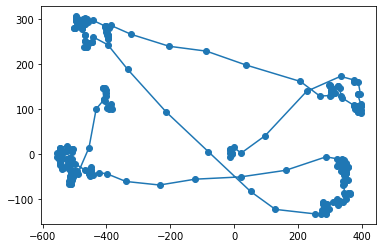

In [ ]:
import matplotlib.pyplot as plt

x,y = zip(*raw_data_list[5])

plt.plot(x,y)
plt.scatter(x,y)

In [ ]:
import matplotlib.pyplot as plt

x,y = zip(*first_same_distance_data_list[12])
# x,y = zip(*reduced_num_of_coor_data_list[12])
# x,y = zip(*second_same_distance_data_list[12])

plt.figure(figsize=(18,18))
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)
plt.plot(x,y,)
plt.scatter(x,y)


save


IndexError: ignored

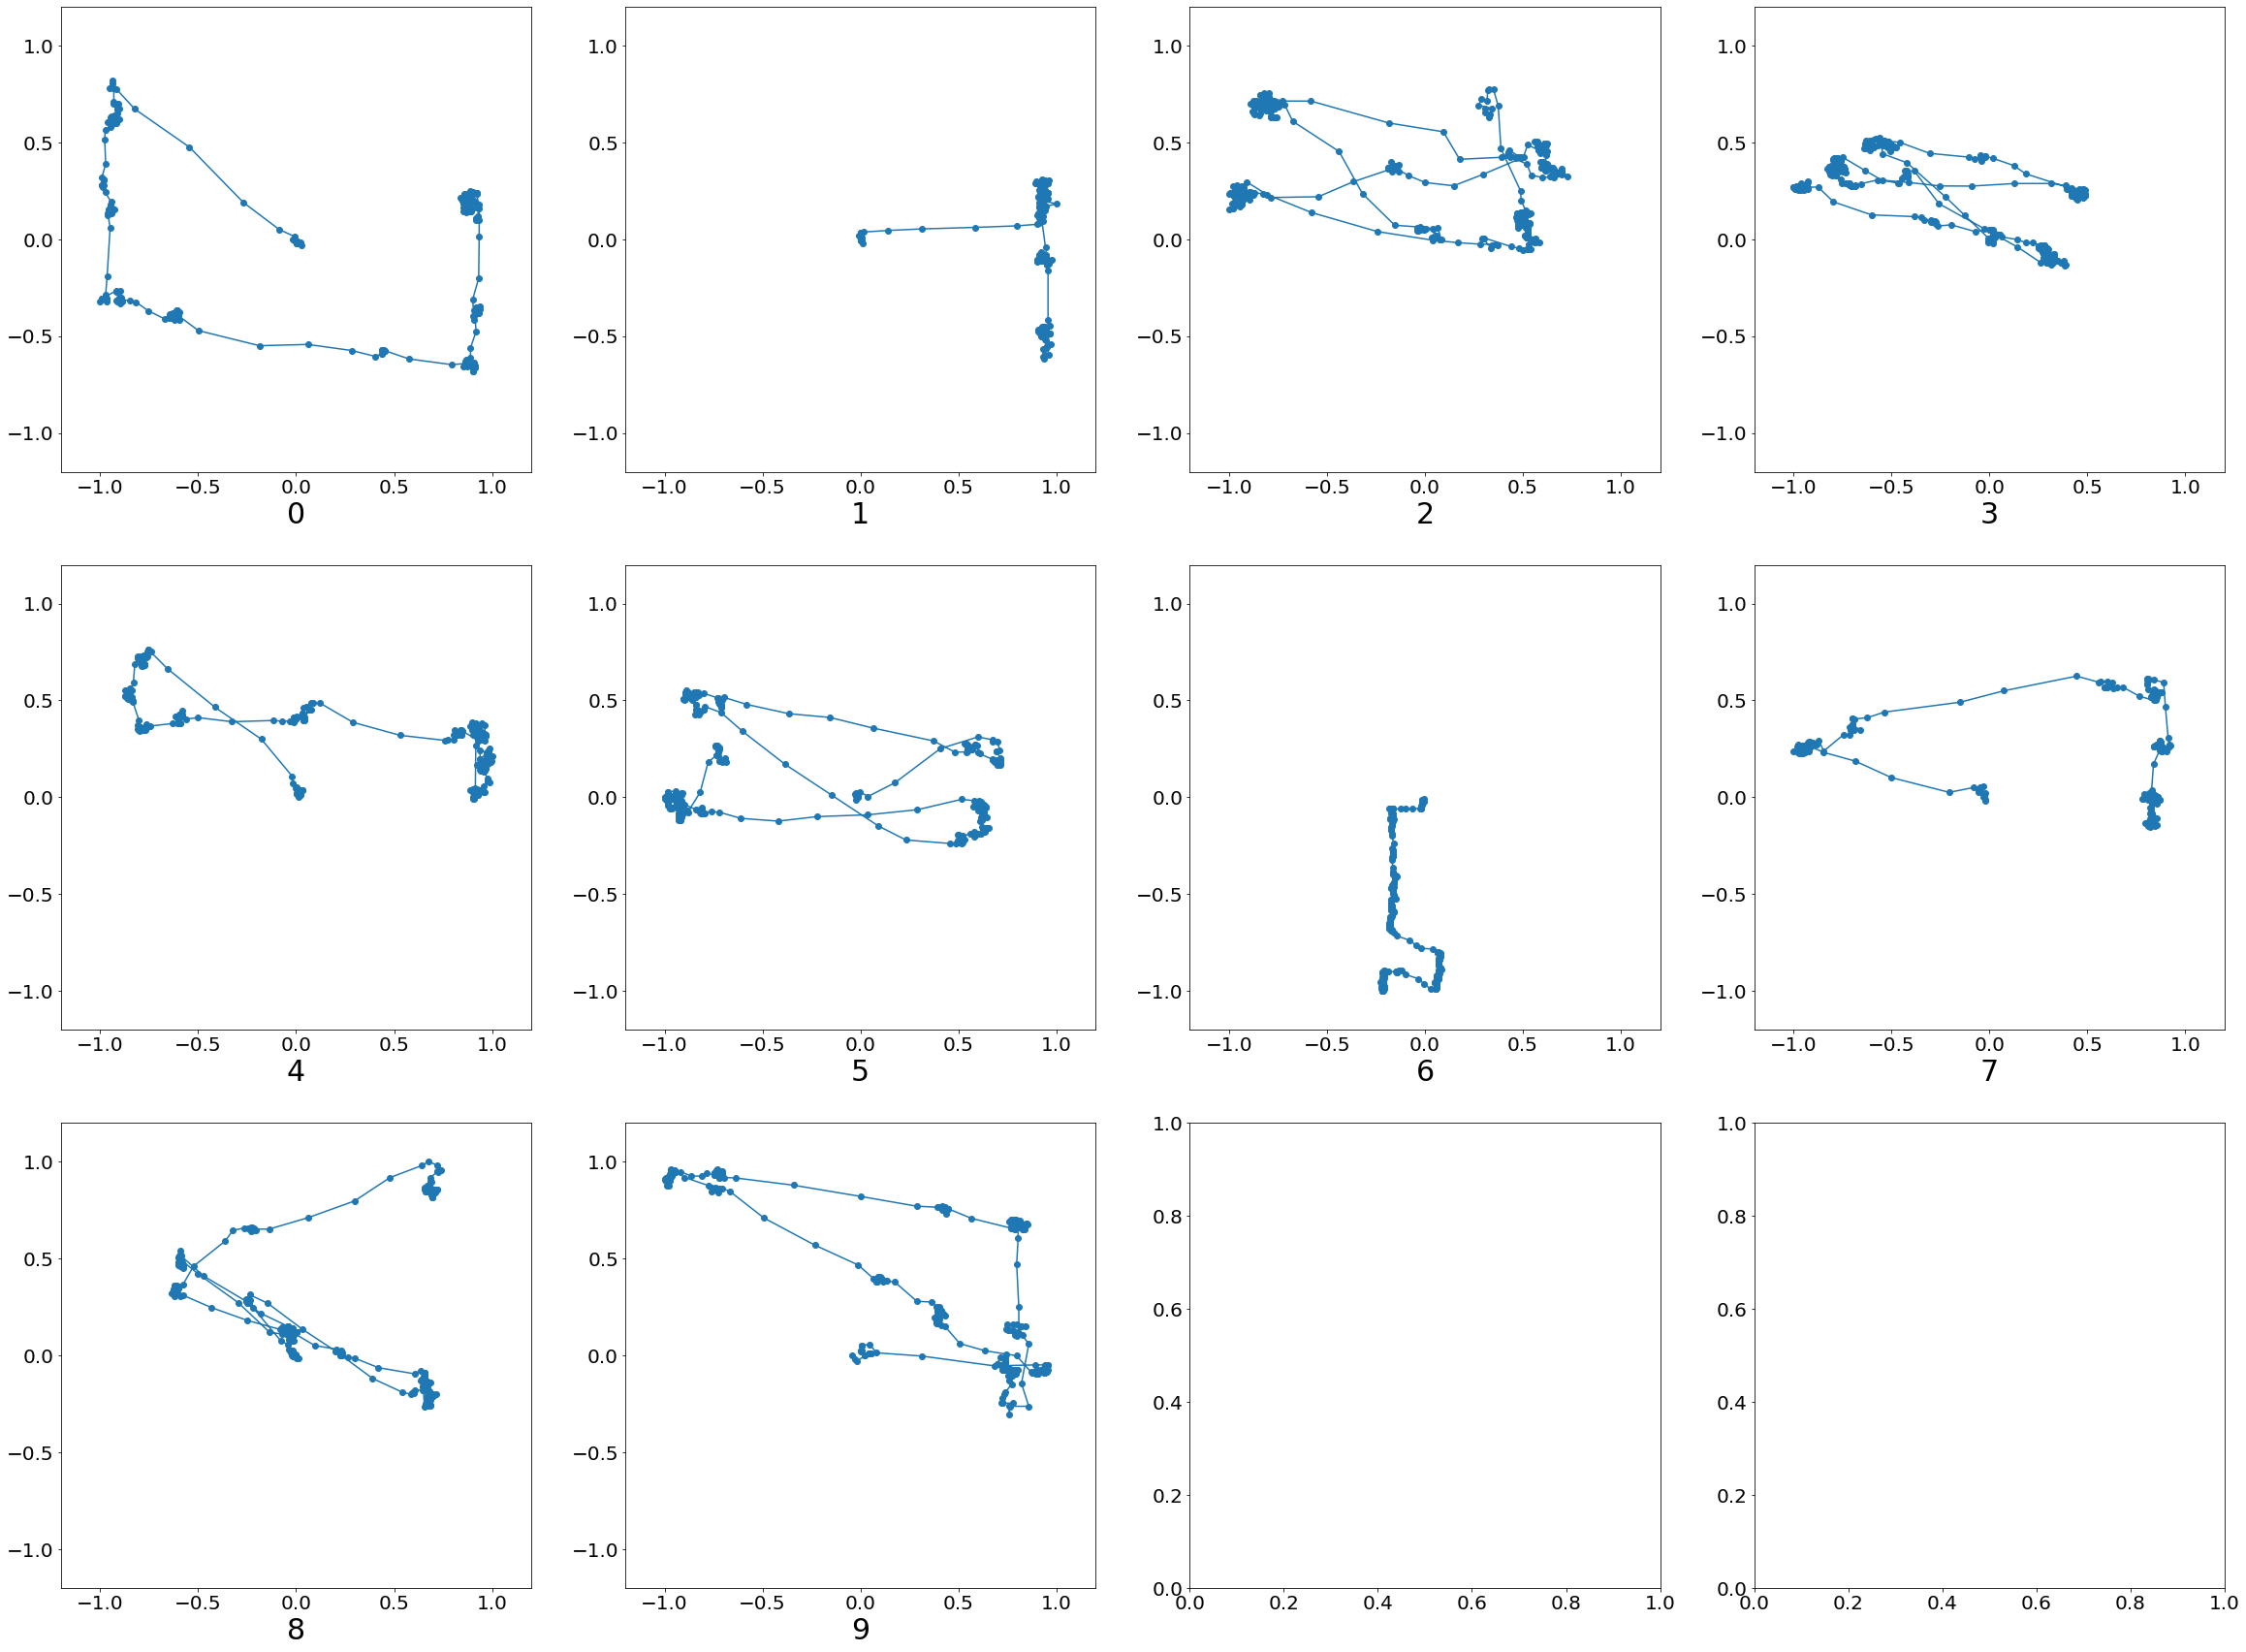

In [ ]:

def plot_images2(input_list,fig,axes):        # input_list plot 함수
 

  exc = ['0',
         '1',
         '2',
         '3',
         '4',
         '5',
         '6',
         '7',
         '8',
         '9']

  n=0
  for i in range(0,3):
    for j in range(0,4):
      
      if n == 10:
        # fig.tight_layout()
        plt.savefig('pre-big.png')
        print('save')
      
      x,y = zip(*input_list[n])
      
      max_val = get_max_coor_val(x,y)
  
      axes[i][j].set_xlim([math.floor(-max_val)*1.2,math.ceil(max_val)*1.2])
      axes[i][j].set_ylim([math.floor(-max_val)*1.2,math.ceil(max_val)*1.2])
  
      axes[i][j].scatter(x,y)
      axes[i][j].plot(x,y)

      axes[i][j].set_xlabel(exc[n], fontsize = 30)

      n += 1

  # display(fig)


# for_paper = [raw_data_list[12],
#              range_convered_data_list[12],
#              noise_removed_data_list[12],
#              coordinates_filled_list[12],
#              first_same_distance_data_list[12],
#              reduced_num_of_coor_data_list[12],
#              second_same_distance_data_list[12]
#              ]


for_paper = [range_convered_data_list[0],
             range_convered_data_list[1],
             range_convered_data_list[2],
             range_convered_data_list[3],
             range_convered_data_list[4],
             range_convered_data_list[5],
             range_convered_data_list[6],
             range_convered_data_list[7],
             range_convered_data_list[8],
             range_convered_data_list[9],
             ]

fig, axes = plt.subplots(3,4,figsize=(40,30))

plot_images2(for_paper, fig,axes)


plt.savefig('pre-big.png')